In [100]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

tqdm.pandas()

In [101]:
npl = spacy.load("en_core_web_sm")

In [102]:
data = pd.read_csv("../data/raw_coref_data.csv", encoding="utf-8", on_bad_lines="skip")

In [103]:
data.text = data.text.progress_apply(lambda x: [sent.text for sent in npl(x).sents])

  0%|          | 0/983 [00:00<?, ?it/s]

In [104]:
data = data.explode("text")

In [105]:
data

,text
0,The system of transliteration from Cyrillic us...
0,The soft sign is denoted by an apostrophe but ...
0,For those countries that changed their officia...
0,Anglicised name-forms are used for the most we...
0,Translations within the text are those of the ...
...,...
982,Many gained skills during World War II or were...
982,The massive deficit of men created permanent ...
982,Through dire necessity Soviet women during Wo...
982,organize would stand Soviet women during the ...


In [106]:
data = data.drop_duplicates()

In [107]:
data.reset_index(drop=True, inplace=True)

In [108]:
data.isna().sum()

text    0
dtype: int64

In [109]:
data.loc[data.text == " "]

,text


In [110]:
tfidf = TfidfVectorizer()

In [111]:
tfidf.fit(data.text)

TfidfVectorizer()

In [112]:
data_vec = tfidf.transform(data.text)

In [113]:
pca_raw = PCA(n_components=2)

In [114]:
data_vec2d = pca_raw.fit_transform(data_vec.toarray())

In [115]:
data_vec2d = pd.DataFrame(data_vec2d, columns=["x", "y"])

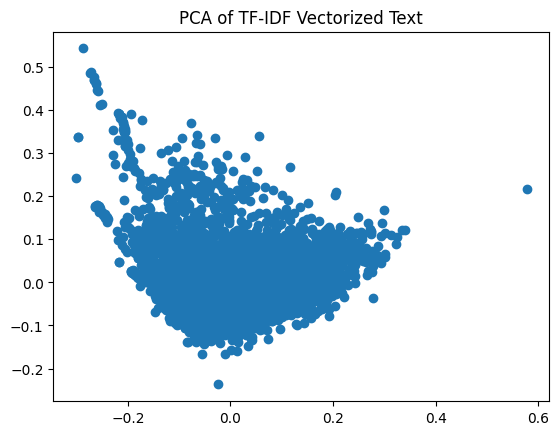

In [116]:
plt.scatter(data_vec2d.x, data_vec2d.y)
plt.title("PCA of TF-IDF Vectorized Text")
plt.show()

In [117]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
labels = dbscan.fit_predict(data_vec2d)
data_vec2d["cluster"] = labels

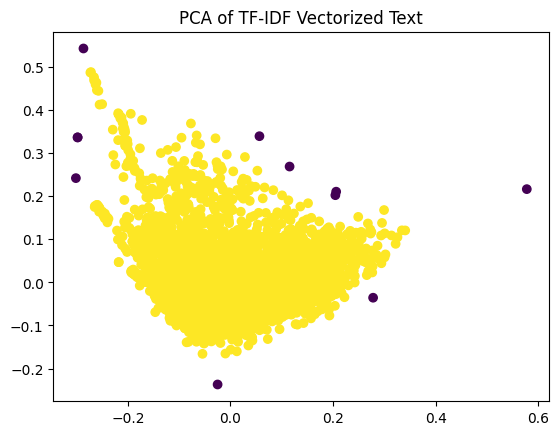

In [118]:
plt.scatter(data_vec2d.x, data_vec2d.y, c=data_vec2d.cluster)
plt.title("PCA of TF-IDF Vectorized Text")
plt.show()

In [119]:
data_pca_and_dbscan = pd.concat([data, data_vec2d], axis=1)

In [120]:
data_pca_and_dbscan["len"] = data_pca_and_dbscan.text.apply(len)

In [121]:
data_pca_and_dbscan = data_pca_and_dbscan.loc[data_pca_and_dbscan.len > 30]

In [122]:
def process_text(text):
    return "".join([char for char in text.lower() if char.isalnum() or char.isspace()]).strip()

In [123]:
data_pca_and_dbscan.text = data_pca_and_dbscan.text.progress_apply(process_text)

  0%|          | 0/7770 [00:00<?, ?it/s]

In [124]:
data_pca_and_dbscan.len = data_pca_and_dbscan.text.apply(len)

In [125]:
from gensim.models import Word2Vec

In [126]:
w2v = Word2Vec(sentences=data_pca_and_dbscan.text.tolist(), vector_size=100, window=5, min_count=1, workers=4)

In [127]:
def sentence_vector(sentence):
    words = sentence.split()
    word_vectors = [w2v.wv[word] for word in words if word in w2v.wv]
    if not word_vectors:
        return np.zeros(w2v.vector_size)
    return np.mean(word_vectors, axis=0)


In [128]:
vectors = data_pca_and_dbscan.copy()
vectors["vector"] = vectors.text.progress_apply(sentence_vector)

  0%|          | 0/7770 [00:00<?, ?it/s]

In [129]:
w2v_pca = PCA(n_components=2)
w2v_pca.fit(vectors["vector"].tolist())

PCA(n_components=2)

In [130]:
w2v_2d = w2v_pca.transform(vectors["vector"].tolist())

In [131]:
w2v_2d = pd.DataFrame(w2v_2d, columns=["x", "y"])
w2v_2d["text"] = vectors.text.reset_index(drop=True)

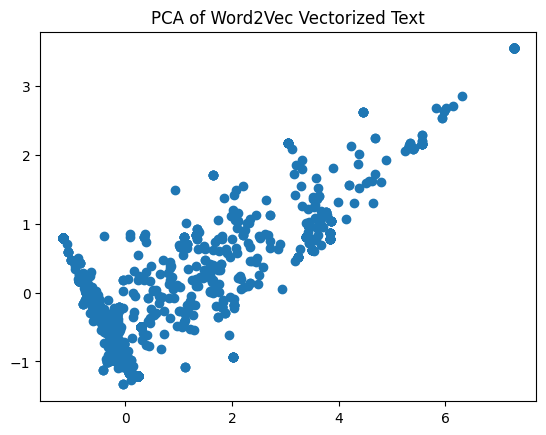

In [132]:
plt.scatter(w2v_2d.x, w2v_2d.y)
plt.title("PCA of Word2Vec Vectorized Text")
plt.show()

In [133]:
dbscan = DBSCAN(eps=0.05)
labels = dbscan.fit_predict(vectors["vector"].tolist())
w2v_2d["cluster"] = labels

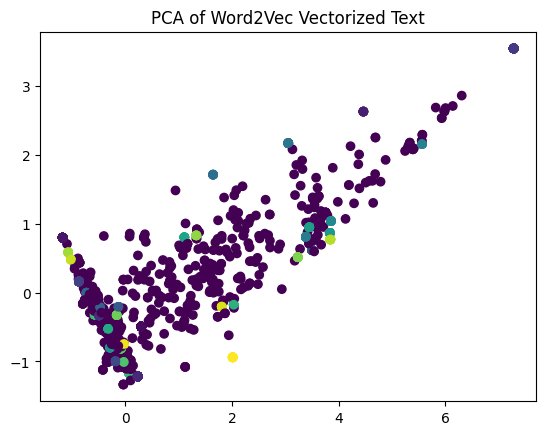

In [134]:
plt.scatter(w2v_2d.x, w2v_2d.y, c=w2v_2d.cluster)
plt.title("PCA of Word2Vec Vectorized Text")
plt.show()

In [135]:
inertia = []
k_range = range(1, 11)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors["vector"].tolist())
    inertia.append(kmeans.inertia_)


  0%|          | 0/10 [00:00<?, ?it/s]

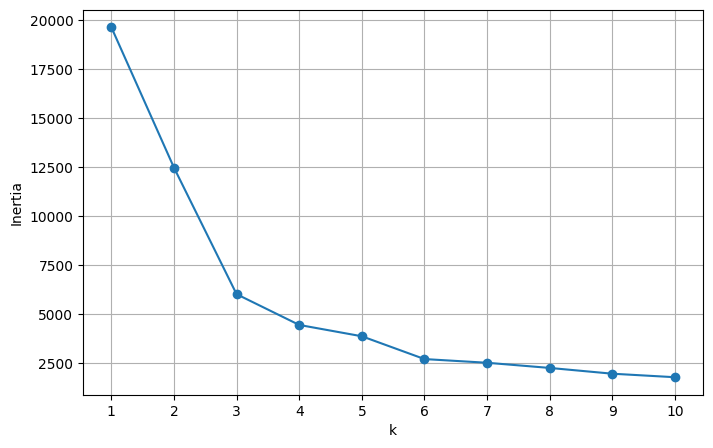

In [136]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.grid()
plt.show()


In [152]:
kmean = KMeans(n_clusters=3, random_state=42)

In [153]:
kmean.fit(vectors["vector"].tolist())

KMeans(n_clusters=3, random_state=42)

In [154]:
clusters = kmean.predict(vectors["vector"].tolist())

In [155]:
vectors.cluster = clusters

In [156]:
xy = pd.DataFrame(w2v_pca.transform(vectors["vector"].tolist()), columns=["x", "y"])

In [157]:
xy

,x,y
0,0.297957,-0.493028
1,0.297957,-0.493028
2,0.297957,-0.493028
3,0.297957,-0.493028
4,0.297957,-0.493028
...,...,...
7765,0.297957,-0.493028
7766,0.297957,-0.493028
7767,0.297957,-0.493028
7768,0.297957,-0.493028


In [158]:
vectors.reset_index(drop=True, inplace=True)

In [159]:
vectors_clustered = pd.concat([vectors.drop(["x", "y"], axis=1), xy], axis=1)

In [160]:
vectors_clustered

,text,cluster,len,vector,x,y
0,the system of transliteration from cyrillic us...,1,117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
1,the soft sign is denoted by an apostrophe but ...,1,189,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
2,for those countries that changed their officia...,1,246,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
3,anglicised nameforms are used for the most wel...,1,186,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
4,translations within the text are those of the ...,1,128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
...,...,...,...,...,...,...
7765,many gained skills during world war ii or were...,1,202,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
7766,the massive deficit of men created permanent ...,1,138,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
7767,through dire necessity soviet women during wo...,1,170,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028
7768,organize would stand soviet women during the ...,1,230,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.297957,-0.493028


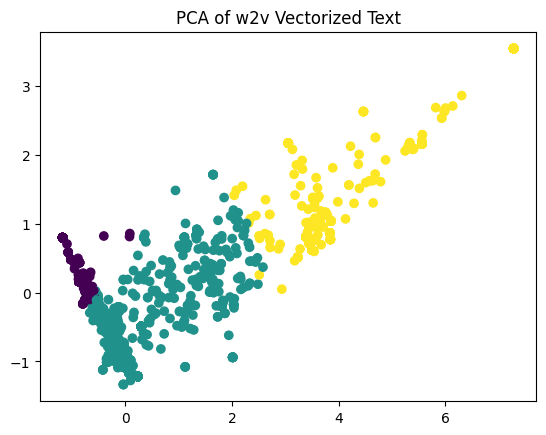

In [161]:
plt.scatter(vectors_clustered.x, vectors_clustered.y, c=vectors_clustered.cluster)
plt.title("PCA of w2v Vectorized Text")
plt.show()

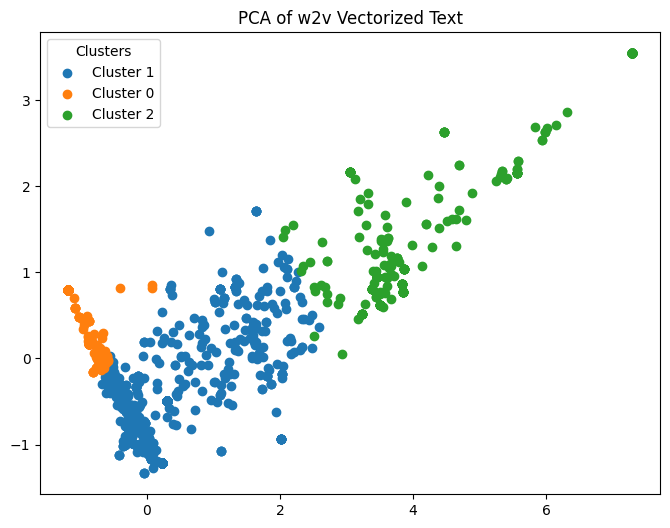

In [162]:
unique_clusters = vectors_clustered.cluster.unique()

plt.figure(figsize=(8, 6))
for cluster in unique_clusters:
    cluster_points = vectors_clustered[vectors_clustered.cluster == cluster]
    plt.scatter(
        cluster_points.x,
        cluster_points.y,
        label=f"Cluster {cluster}"
    )

plt.title("PCA of w2v Vectorized Text")
plt.legend(title="Clusters")
plt.show()

In [169]:
vectors_clustered[vectors_clustered.cluster == 2][["text"]].to_csv("../data/w2vcluster_2.csv", index=False)

In [168]:
vectors_clustered[vectors_clustered.cluster != 2][["text"]].to_csv("../data/w2vcluster_01.csv", index_label="index")